<a href="https://colab.research.google.com/github/jatin-05/Potato-Disease-Classification/blob/main/GPU_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
ImageSize =256
BatchSize =32

In [ ]:
# !git clone https://github.com/jatin-05/Potato-Disease-Classification

Cloning into 'Potato-Disease-Classification'...
remote: Enumerating objects: 2174, done.
remote: Counting objects: 100% (2174/2174), done.
remote: Compressing objects: 100% (2169/2169), done.
remote: Total 2174 (delta 3), reused 2171 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (2174/2174), 38.64 MiB | 39.06 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
# %cd /content/Potato-Disease-Classification/training

/content/Potato-Disease-Classification/training


In [ ]:
dataset = tf.keras.preprocessing .image_dataset_from_directory(
    "PlantVillage" ,
    shuffle=True,
    image_size=(ImageSize,ImageSize) ,
    batch_size = BatchSize
)



Found 2152 files belonging to 3 classes.


In [ ]:

class_names =dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
68*32

2176

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:

for img_batch , label_batch in dataset.take(1):
    print (label_batch)
    print (label_batch.shape)
    print (img_batch[0])


tf.Tensor([1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 2 0 1 1 1 2 1 1 0 0 1 1 1 0 1 1 0], shape=(32,), dtype=int32)
(32,)
tf.Tensor(
[[[ 98.  92.  96.]
  [104.  98. 102.]
  [ 97.  91.  95.]
  ...
  [168. 158. 166.]
  [158. 148. 156.]
  [151. 141. 149.]]

 [[ 89.  83.  87.]
  [112. 106. 110.]
  [113. 107. 111.]
  ...
  [162. 152. 160.]
  [158. 148. 156.]
  [158. 148. 156.]]

 [[121. 115. 119.]
  [110. 104. 108.]
  [ 91.  82.  85.]
  ...
  [155. 145. 153.]
  [158. 148. 156.]
  [164. 154. 162.]]

 ...

 [[121. 111. 120.]
  [115. 105. 114.]
  [109.  99. 108.]
  ...
  [148. 142. 154.]
  [149. 143. 155.]
  [151. 145. 157.]]

 [[123. 113. 122.]
  [115. 105. 114.]
  [110. 100. 109.]
  ...
  [146. 140. 152.]
  [147. 141. 153.]
  [149. 143. 155.]]

 [[117. 107. 116.]
  [110. 100. 109.]
  [108.  98. 107.]
  ...
  [148. 142. 154.]
  [150. 144. 156.]
  [153. 147. 159.]]], shape=(256, 256, 3), dtype=float32)


In [ ]:
plt.figure(figsize=(10,10))
for img_batch , label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.axis('off')
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])



### 80% ==> training
### 20% ==> 10% validation , 10% test

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:


train_Ds = dataset.take(54)
len(train_Ds)

54

In [ ]:
test = dataset.skip(54)
len(test)

14

In [ ]:
val_Ds = test.take(7)
test_Ds = test.skip(7)

In [ ]:
def get_dataset_partitions_tf(ds , train_split= 0.8 , val_split = 0.1 , test_split= 0.1 , shuffle=True , shuffle_size = 1000 ):
    ds_size=len(ds)
    if shuffle :
        ds=ds.shuffle(shuffle_size, seed =12)
        # what does seed do???????

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_Ds = ds.take(train_size)

    val_Ds = ds.skip(train_size).take(val_size)
    test_Ds = ds.skip(train_size).skip(val_size)

    return train_Ds , val_Ds , test_Ds



In [ ]:


train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(test_ds)

8

In [ ]:
len(val_ds)

6

In [ ]:
#cache stores the data in cache for the next epoch
# prefetch--> CPU fetches the next batch while GPU is trining the current batch (but you dont have a GPU :)  )
# buffer_size lets it decide how many batch to load while GPU is training

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
# train_ds = train_ds.map(lambda x: x/255)
resize_and_rescale= tf.keras.Sequential([
    layers.Resizing(ImageSize, ImageSize),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical") ,
    layers.RandomRotation(0.2)
])

# model

In [ ]:

input_shape = ( BatchSize ,ImageSize , ImageSize , 3)
def get_model():
  model = models.Sequential([
      resize_and_rescale ,
      data_augmentation ,
      layers.Conv2D(32 , (3,3) ,activation='relu' , input_shape = input_shape),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64 , (3,3) ,activation='relu' ),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64 , (3,3) ,activation='relu' ),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64 , (3,3) ,activation='relu' ),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64 , (3,3) ,activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64 , (3,3) ,activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Flatten() ,
      layers.Dense(64 , activation= 'relu'),
      layers.Dense(3 , activation= 'softmax'),


  ])
  model.build(input_shape=input_shape)
  model.compile(
    optimizer = 'adam' ,
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics= ['accuracy']

 )
  return model

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:


with tf.device('/GPU:0'):
  gmodel=get_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
  history = gmodel.fit(
    train_ds ,
    epochs=50 ,
    batch_size = BatchSize ,
    verbose =1 ,
    validation_data = val_ds ,


)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.4372 - loss: 0.9440 - val_accuracy: 0.7188 - val_loss: 0.7598
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6974 - loss: 0.6625 - val_accuracy: 0.8281 - val_loss: 0.3723
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8395 - loss: 0.3848 - val_accuracy: 0.8490 - val_loss: 0.3197
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8894 - loss: 0.2925 - val_accuracy: 0.8385 - val_loss: 0.3433
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8789 - loss: 0.2612 - val_accuracy: 0.8438 - val_loss: 0.3493
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9116 - loss: 0.2287 - val_accuracy: 0.8646 - val_loss: 0.3442
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9153 - loss: 0.2368 - val_accuracy: 0.9115 - val_loss: 0.2025
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9470 - loss: 0.1471 - val_accuracy: 0.8750 -

In [ ]:
score  = gmodel.evaluate(test_ds )

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9339 - loss: 0.2060


In [ ]:
score

[0.22136282920837402, 0.92578125]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history['accuracy']

[0.5127314925193787,
 0.7401620149612427,
 0.8454861044883728,
 0.8831018805503845,
 0.8940972089767456,
 0.9160879850387573,
 0.9160879850387573,
 0.9508101940155029,
 0.9548611044883728,
 0.9542824029922485,
 0.9565972089767456,
 0.9554398059844971,
 0.9658564925193787,
 0.9774305820465088,
 0.9803240895271301,
 0.9722222089767456,
 0.9699074029922485,
 0.9809027910232544,
 0.9803240895271301,
 0.9797453880310059,
 0.9652777910232544,
 0.9866898059844971,
 0.9612268805503845,
 0.9895833134651184,
 0.9814814925193787,
 0.9733796119689941,
 0.9855324029922485,
 0.9785879850387573,
 0.9797453880310059,
 0.9803240895271301,
 0.9895833134651184,
 0.9913194179534912,
 0.9861111044883728,
 0.9895833134651184,
 0.9953703880310059,
 0.9849537014961243,
 0.9861111044883728,
 0.9947916865348816,
 0.9797453880310059,
 0.9890046119689941,
 0.9924768805503845,
 0.9913194179534912,
 0.9930555820465088,
 0.9803240895271301,
 0.984375,
 0.9878472089767456,
 0.9901620149612427,
 0.9907407164573669,
 0

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50) , acc)

plt.plot(range(50) , val_acc)
plt.subplot(1,2,2)
plt.plot(range(50) , loss)
plt.plot(range(50) , val_loss)

In [ ]:
import numpy as np
for img , lab in test_ds.take(1):
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.title(class_names[lab[0].numpy()])

    batch_pred = gmodel.predict(img)
    print(class_names[np.argmax(batch_pred[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Potato___Early_blight


In [ ]:
batch_pred[0]

array([9.9998927e-01, 1.0706695e-05, 7.2232964e-14], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


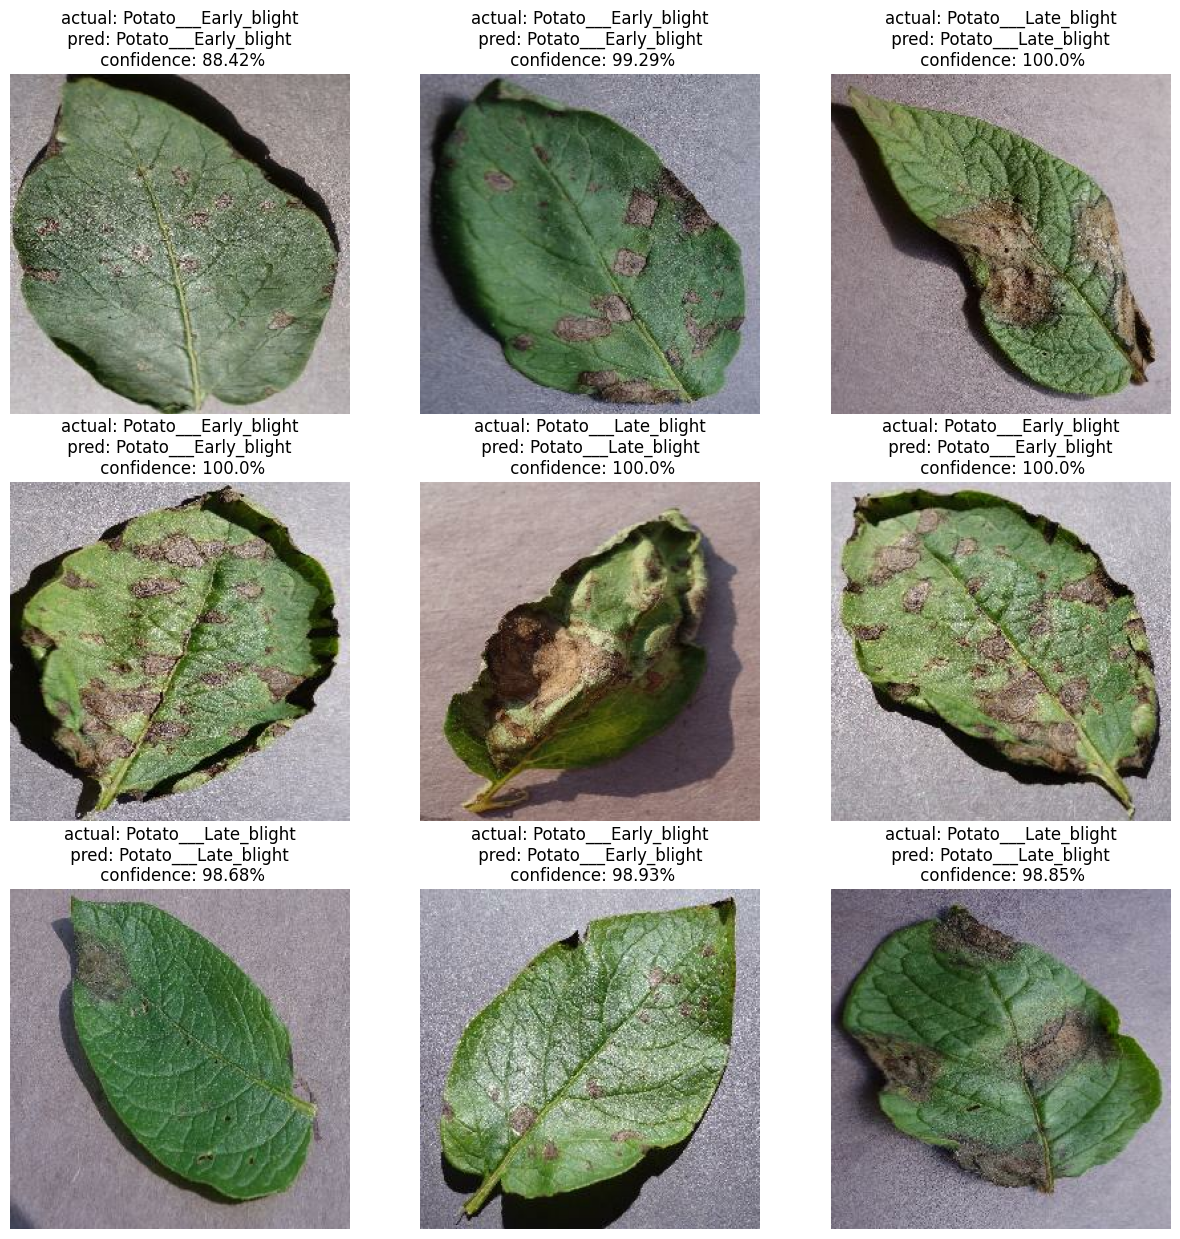

In [ ]:
plt.figure(figsize=(15,15))
for img , lab in test_ds.take(1):
  for i in range (9):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.imshow(img[i].numpy().astype('uint8'))
    # plt.title(class_names[lab[i].numpy()])

    batch_pred = gmodel.predict(img)

    confidence = round(100 * np.max(batch_pred[i]), 2)


    pred = class_names[np.argmax(batch_pred[i])]
    plt.title(f"actual: {class_names[lab[i].numpy()] }\n pred: {pred} \n confidence: {confidence}%")

In [ ]:
model_version = 1
gmodel.export(f"{model_version}")

Saved artifact at '1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134651979395344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134651979395536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134649819967376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134649819967952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134649819968528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134649819967568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134649819970256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134649819968720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134649819969488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134649819971216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134649819971024: TensorSpec(s